In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing

### Import Data

In [2]:
## import data
df = pd.read_csv("transactions_n100000.csv")
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234


In [3]:
## transfer to datetime
df['order_timestamp'] = pd.to_datetime(df['order_timestamp']) 
df['order_hour']=df['order_timestamp'].dt.hour
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long,order_hour
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605,18
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605,18
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605,18
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234,11
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234,11


In [4]:
## see if there is any NA
df.isna().count()

ticket_id          260741
order_timestamp    260741
location           260741
item_name          260741
item_count         260741
lat                260741
long               260741
order_hour         260741
dtype: int64

In [5]:
## Drop useless columns
df1=df.drop(['lat','long','order_timestamp'],axis=1)
df1.head()

,ticket_id,location,item_name,item_count,order_hour
0,0x872a40,4,shake,2,18
1,0x872a40,4,burger,2,18
2,0x872a40,4,fries,2,18
3,0x598eb3,5,burger,1,11
4,0x598eb3,5,salad,2,11


In [6]:
## Cluster the order
item_counts = pd.pivot_table(data = df1,index ='ticket_id',columns = 'item_name',values = 'item_count',aggfunc='sum')
item_counts.fillna(0,inplace=True)
item_counts.head()

item_name,burger,fries,salad,shake
ticket_id,,,,
0x100048,0.0,3.0,3.0,0.0
0x100057,1.0,1.0,0.0,0.0
0x1000ba,1.0,2.0,1.0,1.0
0x1000fb,4.0,5.0,1.0,4.0
0x10016e,3.0,3.0,0.0,3.0


In [7]:
order_info = df1
order_info = order_info.drop(['item_name','item_count'], axis='columns')
order_info = order_info.drop_duplicates("ticket_id", keep='first').reset_index(drop=True)

In [8]:
df2=item_counts.merge(order_info,'left',on='ticket_id')

In [9]:
df2.head()

,ticket_id,burger,fries,salad,shake,location,order_hour
0,0x100048,0.0,3.0,3.0,0.0,1,12
1,0x100057,1.0,1.0,0.0,0.0,6,0
2,0x1000ba,1.0,2.0,1.0,1.0,5,12
3,0x1000fb,4.0,5.0,1.0,4.0,4,19
4,0x10016e,3.0,3.0,0.0,3.0,7,17


In [10]:
df2.drop('ticket_id',inplace=True,axis=1)

In [11]:
df_order=pd.get_dummies(df2,prefix='location',prefix_sep='_',columns=['location'])

In [12]:
df_order=pd.get_dummies(df_order,prefix='order_hour',prefix_sep='_',columns=['order_hour'])

In [13]:
df_order.head()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,...,order_hour_14,order_hour_15,order_hour_16,order_hour_17,order_hour_18,order_hour_19,order_hour_20,order_hour_21,order_hour_22,order_hour_23
0,0.0,3.0,3.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2.0,1.0,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,5.0,1.0,4.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3.0,3.0,0.0,3.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# K_means store clustering

In [14]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(df_order)
    sse[k] = kmeans.inertia_ 

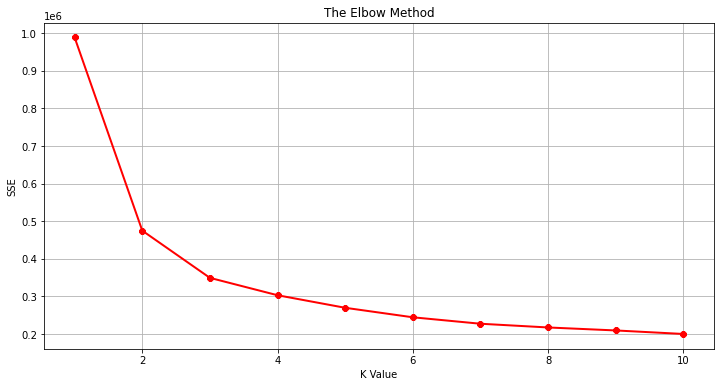

In [15]:
plt.figure(figsize=(12,6)) 
plt.grid()
plt.plot(list(sse.keys()),list(sse.values()), linewidth=2, color="red", marker ="8")
plt.title('The Elbow Method')
plt.xlabel('K Value')
plt.ylabel('SSE')
plt.show()


In [16]:
##seems MinMaxScaler is more reasonable
scaler=MinMaxScaler()
scaler.fit(df_order)
df_order_norm=scaler.transform(df_order)

In [17]:
df_order_norm

array([[0.  , 0.5 , 0.6 , ..., 0.  , 0.  , 0.  ],
       [0.2 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.2 , 0.25, 0.2 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.2 , ..., 0.  , 0.  , 0.  ],
       [0.2 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.6 , 0.5 , 0.  , ..., 0.  , 0.  , 0.  ]])

In [18]:
## with normalization
sse2 = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=68)
    kmeans.fit(df_order_norm)
    sse2[k] = kmeans.inertia_ 

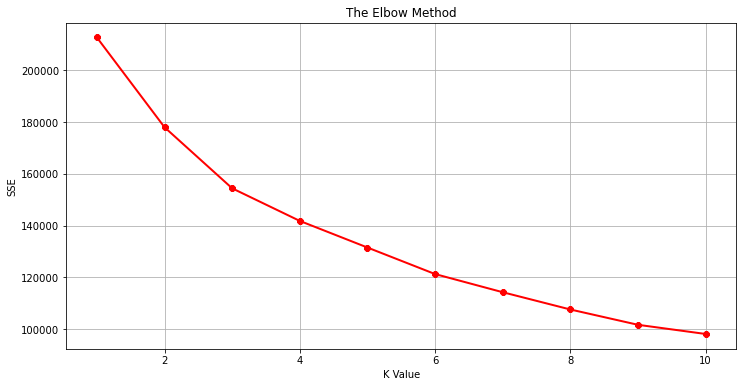

In [19]:
plt.figure(figsize=(12,6)) 
plt.grid()
plt.plot(list(sse2.keys()),list(sse2.values()), linewidth=2, color="red", marker ="8")
plt.title('The Elbow Method')
plt.xlabel('K Value')
plt.ylabel('SSE')
plt.show()



In [20]:
##假设k=5
kmeans_5=KMeans(n_clusters=5).fit(df_order_norm)
sse_5=kmeans_5.inertia_
y_kmeans_5=kmeans_5.predict(df_order_norm)

In [21]:
kmeans_5.labels_

array([2, 1, 2, ..., 2, 3, 0], dtype=int32)

In [22]:
kmeans_5.cluster_centers_

array([[ 7.12175510e-01,  6.84158932e-01,  3.51516355e-02,
         6.61815655e-01,  2.90862163e-02,  2.49664963e-02,
         2.82920534e-02,  2.77262123e-01,  2.96818385e-02,
         2.26336427e-02,  2.70213928e-01,  3.94599692e-02,
         2.78403733e-01,  6.40293840e-03,  7.24673649e-03,
         1.48905544e-04,  5.82867088e-16,  1.98540726e-04,
         1.24087954e-03,  8.63652157e-03,  8.68119323e-02,
         3.84325210e-01,  2.80331314e-15,  3.94947139e-01,
         9.19243560e-02,  9.33141411e-03,  2.97811088e-04,
         8.48761602e-03],
       [ 3.33492888e-01,  2.09210886e-01,  3.38758206e-02,
         6.64660832e-02,  4.30211422e-16, -3.85802501e-15,
         3.19189120e-16, -4.27435864e-15, -1.23512311e-15,
         1.00000000e+00,  1.31838984e-15,  2.83106871e-15,
         1.59594560e-15,  6.15973742e-01,  1.45787746e-01,
         2.02407002e-02,  2.84463895e-02,  1.88730853e-02,
         6.56455142e-03,  9.57330416e-04,  2.25656455e-03,
         4.10284464e-03,  2.11

In [23]:
y_result=pd.DataFrame(y_kmeans_5)
result=pd.concat((pd.DataFrame(df_order_norm,columns=df_order.columns),y_result),axis=1)
result.rename({0:'Cluster'},axis=1,inplace=True)
result.head()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,...,order_hour_15,order_hour_16,order_hour_17,order_hour_18,order_hour_19,order_hour_20,order_hour_21,order_hour_22,order_hour_23,Cluster
0,0.0,0.50,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.2,0.25,0.2,0.2,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.8,1.00,0.2,0.8,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.6,0.50,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
grouped_cluster=result.groupby(by=['Cluster']).sum()
grouped_cluster.T

Cluster,0,1,2,3,4
burger,14348.20,4877.0,2707.4,6329.20,8907.40
fries,13783.75,3059.5,10152.5,3689.75,8531.25
salad,708.20,495.4,12118.4,402.40,479.80
shake,13333.60,972.0,881.4,1197.40,8445.40
location_1,586.00,0.0,6995.0,707.00,394.00
location_2,503.00,0.0,508.0,14385.00,375.00
location_3,570.00,0.0,6982.0,711.00,428.00
location_4,5586.00,0.0,1652.0,654.00,3446.00
location_5,598.00,0.0,6894.0,417.00,398.00
location_6,456.00,14624.0,183.0,0.00,344.00


In [25]:
## Try K=3
def K_mean_opt(df,k):
    kmeans=KMeans(n_clusters=k, random_state = 33).fit(df)
    y_kmeans=kmeans.predict(df)
    y_result=pd.DataFrame(y_kmeans)
    result=pd.concat((pd.DataFrame(df,columns=df_order.columns),y_result),axis=1)
    result.rename({0:'Cluster'},axis=1,inplace=True)
    grouped_cluster=result.groupby(by=['Cluster']).sum()
    final_grouped=grouped_cluster.T
    return final_grouped


In [26]:
grouped_k3=K_mean_opt(df_order_norm,3)
grouped_k3

Cluster,0,1,2
burger,10828.4,23452.00,2888.8
fries,6078.5,22522.75,10615.5
salad,313.8,1168.80,12721.6
shake,2012.4,21863.60,953.8
location_1,723.0,930.00,7029.0
location_2,13419.0,1053.00,1299.0
location_3,724.0,951.00,7016.0
location_4,665.0,8998.00,1675.0
location_5,428.0,950.00,6929.0
location_6,13383.0,975.00,1249.0


# GMM Store Clustring

In [27]:
from sklearn.mixture import GaussianMixture

In [28]:
def GMM_opt(df,k):
    clf=GaussianMixture(n_components=k, random_state = 33)
    clf.fit(df)
    y_predict=clf.predict(df)
    y_predict=pd.DataFrame(y_predict)
    final_result=pd.concat((pd.DataFrame(df,columns=df_order.columns),y_predict),axis=1)
    final_result.rename({0:'GMM'},axis=1,inplace=True)
    grouped_cluster=final_result.groupby(by=['GMM']).sum()
    final_grouped=grouped_cluster.T
    return final_grouped

In [29]:
GMM_group=GMM_opt(df_order_norm,3)

In [30]:
GMM_group
#Pattern is clear!

GMM,0,1,2
burger,11799.2,23042.20,2327.8
fries,6834.5,22215.25,10167.0
salad,409.2,1529.20,12265.8
shake,2172.0,21776.60,881.2
location_1,1115.0,1169.00,6398.0
location_2,13348.0,1074.00,1349.0
location_3,1079.0,1189.00,6423.0
location_4,1013.0,8974.00,1351.0
location_5,716.0,1194.00,6397.0
location_6,13270.0,1037.00,1300.0


In [31]:
clf=GaussianMixture(n_components=3)
clf.fit(df2.iloc[:,1:5])
segment=clf.predict(df2.iloc[:,1:5])
df2['segment'] = segment

# Product Portfolio Clustering

In [32]:
km = KMeans(n_clusters=7, random_state = 33)
bundle = km.fit_predict(df2.iloc[:,1:5])
df2["bundle"] = bundle
df2.head()

,burger,fries,salad,shake,location,order_hour,segment,bundle
0,0.0,3.0,3.0,0.0,1,12,0,6
1,1.0,1.0,0.0,0.0,6,0,0,4
2,1.0,2.0,1.0,1.0,5,12,1,4
3,4.0,5.0,1.0,4.0,4,19,1,5
4,3.0,3.0,0.0,3.0,7,17,2,2


In [33]:
df2.to_csv('result.csv')

In [34]:
#计算各类别下的样本量和比率
cluster_count = pd.DataFrame(df2.groupby('bundle')['burger'].count()).T.rename({'burger':'counts'})
cluster_percent = (cluster_count/len(df2)).round(2).rename({'counts':'percent'})

# 数值变量统计均值，类别变量统计众数
cluster_feature=[]
for i in range(7):
    cluster_data = df2[df2['bundle']== i] #取出某一个类别的数据
    #取出数值型变量
    num_data = cluster_data.iloc[:,[0,1,2,3]]
    num_data_des = num_data.describe().round(0)
    data1= num_data_des.iloc[1,:]
    cluster_feature.append(data1)

cluster_data = pd.DataFrame(cluster_feature).reset_index(drop=True).T
result = pd.concat((cluster_count,cluster_percent,cluster_data),axis=0)
print('{:-^60}'.format('Patterns of Every Segment'))
print(result)

-----------------Patterns of Every Segment------------------
                0        1         2        3         4         5       6
counts   12381.00  20493.0  16846.00  8392.00  20730.00  11572.00  9586.0
percent      0.12      0.2      0.17     0.08      0.21      0.12     0.1
burger       1.00      1.0      4.00     1.00      1.00      4.00     1.0
fries        2.00      1.0      4.00     3.00      1.00      4.00     3.0
salad        1.00      0.0      0.00     2.00      0.00      0.00     2.0
shake        0.00      0.0      4.00     0.00      0.00      4.00     0.0
